# 7. Base-station side: Physical Broadcast Channel in 5G Networks
The Physical Broadcast Channel (PBCH) carries the Master Information Block (MIB). The MIB contains essential information for downlink synchronization of user equipment, such as cell identity, system bandwidth, and configurations of other channels. In this experiment, the complete implementation of the PBCH chain is discussed in detail.

## 7.1 Import Libraries
### 7.1 Import Python and SDR Libraries

In [1]:

# %matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import sionna as sn
import adi
import matplotlib.pyplot as plt


### 7.1 Import 5G Toolkit Libraries 

In [2]:

import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualizationPBCH, DMRSParameterDetection, CarrierFrequencyOffsetEstimation
from toolkit5G.OFDM               import OFDMDemodulator
from toolkit5G.PhysicalChannels   import PBCHDecoder


### 7.1 Import PBCH Components

In [3]:

from toolkit5G.PayloadGeneration import MIBGeneration
from toolkit5G.PayloadGeneration import MIBExtraction

from toolkit5G.PhysicalChannels.PBCH   import PBCHInterleaver
from toolkit5G.PhysicalChannels.PBCH   import PBCHDeInterleaver
from toolkit5G.ChannelCoder.PolarCoder import InputBitInterleaver
from toolkit5G.ChannelCoder.PolarCoder import InputBitDeInterleaver
from toolkit5G.Ratematcher.PolarCoder  import Subblock_Interleaver
from toolkit5G.Ratematcher.PolarCoder  import Subblock_DeInterleaver
from toolkit5G.Ratematcher.PolarCoder  import ChannelDeInterleaver
from toolkit5G.Ratematcher.PolarCoder  import ChannelInterleaver

from toolkit5G.Ratematcher.PolarCoder  import BitSelection
from toolkit5G.Ratematcher.PolarCoder  import BitDeSelection
from toolkit5G.ChannelCoder            import PolarEncoder5G
from toolkit5G.ChannelCoder     import PolarDecoder5G

# from ChannelCoder.PolarCoder.polarEncoder5G import InputBitDeInterleaver
from toolkit5G.Scrambler        import Scrambler
from toolkit5G.Scrambler        import DeScrambler
from toolkit5G.CRC              import CRCEncoder
from toolkit5G.CRC              import CRCDecoder
from toolkit5G.SymbolMapping    import Demapper
from toolkit5G.SymbolMapping    import Mapper


## 7.1 Emulation Configurations

In [4]:

# System Parameters
center_frequency    = 1e9     # Carrier frequency for signal transmission

# OFDM Parameters
Bandwidth           = 10*10**6 # bandwidth
fftSize             = 1024    # FFT-size for OFDM
subcarrier_spacing  = 30000   # Subcarrier spacing
numOFDMSymbols      = 14      # Number of OFDM symbols considered for emulation | 1 slot
sample_rate         = fftSize*subcarrier_spacing # sample rate required by OFDM and DAC/ADC of SDR

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(4*fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


## 7.1 PBCH Payload Generation: MIB + ATI

In [5]:

nSymbolFrame= 140*int(subcarrier_spacing/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftsize = fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff          # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
fftsize     = tfParams.fftsize       # FFT-size for OFDM
lengthCP    = tfParams.lengthCP      # CP length

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, isPairedBand = False, 
                                                             intraFrequencyReselection = "allowed", 
                                                             withSharedSpectrumChannelAccess = False,
                                                             ssbSubCarrierOffset = 0)

systemFrameNumber               = ssbParameters.systemFrameNumber 
subCarrierSpacingCommon         = ssbParameters.subCarrierSpacingCommon 
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset #ssbParameters.ssbSubCarrierOffset 
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition 
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset 
choiceBit                       = ssbParameters.choiceBit 
ssbType                         = ssbParameters.ssbType 
nssbCandidatesInHrf             = 4     #ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit 
cellBarred                      = ssbParameters.cellBarred 
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection 
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

nFrames                         = 0.5
Nsc_ssb                         = 240  # Numbers of subcarriers in SSB
Nsymb_ssb                       = 4    # Numbers of OFDM symbols in SSB


## 7.1 PSS, SSS, PBCH, DMRS Generation

In [6]:

N_ID2        = np.random.randint(3)   # N_ID2 can take values of 0,1 and 2.

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()   # PSS sequence

N_ID1        = np.random.randint(336) # N_ID1 can take values ranging from 0 to 335.
N_ID         = 3*N_ID1 + N_ID2        # Calculating Physical Cell ID.

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2)
sssSequence  = sssObject()      # SSS Sequence

# Generate DMRS sequence
dmrsLen      = 144                    # length of DMRS sequence.   
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
dmrsSequence = dmrsObject(dmrsLen)    # DMRS sequence


## 7.1 PBCH: Transmitter

![PBCH](PBCH.svg)

In [7]:
# *********************************************************************************
#
# # Generate PBCH symbols
# pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
#                    controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
#                    systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
#                    nssbCandidatesInHrf)
#
# pbchSymbols  = pbchObject()           # PBCH payload symbol (QPSK modulated)
#
# *********************************************************************************

mib        = MIBGeneration(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                           controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                           systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex)
payloadMIB = mib()

pbchIL     = PBCHInterleaver()
ilBits     = pbchIL(payloadMIB)

pbchScr    = Scrambler("PBCH-1", N_ID, nssbCandidatesInHrf)
scrBits    = pbchScr(ilBits)

crcEncoder = CRCEncoder("CRC24C")
payloadCRC = crcEncoder(scrBits)

pbch_IiL   = InputBitInterleaver()
iILBits    = pbch_IiL(payloadCRC)

K          = iILBits.shape[1]
E          = 864
purpose    = "PBCH"
verbose    = 0
encoder    = PolarEncoder5G(K, E, purpose, verbose)
encBits    = encoder(iILBits)
N          = encBits.shape[1]

sbBIL      = Subblock_Interleaver()
sbBil_bits = sbBIL(encBits)

rm         = BitSelection(K, N, E)
rmBits     = rm(sbBil_bits)

chIL       = ChannelInterleaver()
chIL_bits  = chIL(rmBits)

pbchScr2   = Scrambler("PBCH-2", N_ID, nssbCandidatesInHrf, ssbIndex)
scr2Bits   = pbchScr2(chIL_bits)

# The mapper maps blocks of information bits to constellation symbols
modOrder   = 2
mapper     = Mapper("qam", modOrder)
pbchSymbols= mapper(scr2Bits)


## 7.1 Constellation Diagram: Base Station

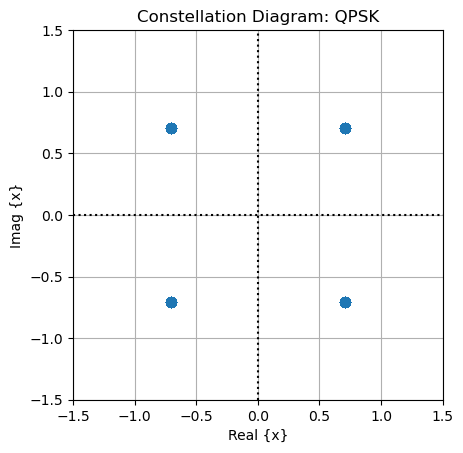

In [8]:
fig, ax = plt.subplots()
ax.set_aspect(True)
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()

## 7.1 SSB Generation

In [9]:
## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols) # generating SSB using PSS,SSS, PBCH payload and DMRS.   

## Loading SSB to Resource Grid

ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1 

ssbRGobject    = ResourceMapperSSB(ssbType, center_frequency, isPairedBand, withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset,
                      offsetInRBs = 0, numRBs = nRB)[0:14]                  # SSB Grid of size 14 X numbers of RBs x 12.

## 7.1 OFDM Implementation

In [10]:
## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftsize - Neff)/2), int((fftsize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

X = np.zeros((numOFDMSymbols, fftsize), dtype= np.complex64)  # Generating grid of size 14 X  FFT_Size.
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid   # Loading SSB into grid.

### OFDM Modulation at Transmitter
modulator = OFDMModulator(lengthCP[1]) # OFDM modulation
x_time    = modulator(X).flatten()     # Time domain samples from OFDM modulation.

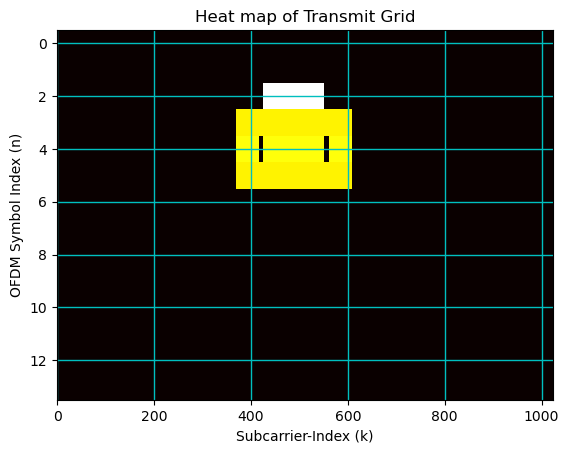

In [11]:
### Plot Resource Grid
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 7.1 SDR Setup

In [12]:

# SDR setup
sdr             = adi.Pluto("ip:192.168.3.1")       # Create object of SDR setup object and configure the IP of SDR connect to the system
sdr.sample_rate = int(sample_rate)                  # Sets the sample rate for the ADC/DAC of the SDR.

# Config Tx
sdr.tx_rf_bandwidth         = int(sample_rate)      # Set the bandwidth of the transmit filter | Can be set same as the sample rate
# For Pluto SDR, tx_rf_bandwidth should be between 200 kHz and 56 MHz.
sdr.tx_lo                   = int(center_frequency) # Sets the transmitter local oscillator frequency. The carrier is used to modulate/up-convert the analog information signal.
# For Pluto SDR, tx_lo can take a value between 325 MHz to 3.8 GHz.
sdr.tx_hardwaregain_chan0   = 0                     # Sets the gain (dB) of the transmitter power amplifier. The higher the value the more the power radiated by antenna. 
# For Pluto SDR, tx_hardwaregain_chan0 can take values between -90 to 0.


## 7.1 Transmission

In [13]:

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers

sdr.tx(1.4*2**17*(x_time.repeat(1))) # start transmitting


## MIB Information: Transmitted

In [14]:
mib.displayParameters(0)

Carrier Frequency:	1000000000.0
ChoiceBit:  		1
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	5
searchSpace0: 		7
cellBarred: 		barred
intraFreqReselection: 	allowed
systemFrameNumber: 	367
ssbSubCarrierOffset: 	0
HRFBit: 		0
iSSBindex: 		0
